我们在Adagrad里提到，由于学习率分母上的变量ss一直在累加按元素平方的梯度，每个元素的学习率在迭代过程中一直在降低或不变。所以在有些问题下，当学习率在迭代早期降得较快时且当前解依然不理想时，Adagrad在迭代后期可能较难找到一个有用的解。

为了应对这一问题，RMSProp算法对Adagrad做了一点小小的修改。

### RMSProp算法

RMSProp算法会使用一个梯度按元素平方的指数加权移动平均变量s，并将其中每个元素初始化为0。在每次迭代中，首先计算小批量梯度 g，然后对该梯度按元素平方后做指数加权移动平均并计算s：

s:=γs+(1−γ)g⊙g

然后我们将模型参数中每个元素的学习率通过按元素操作重新调整一下：

g′:=η/√(s+ϵ)⊙g

其中η是初始学习率，ϵ是为了维持数值稳定性而添加的常数，例如10−8。和Adagrad一样，模型参数中每个元素都分别拥有自己的学习率。

同样地，最后的参数迭代步骤与小批量随机梯度下降类似。只是这里梯度前的学习率已经被调整过了：

x:=x−g′

需要强调的是，RMSProp只在Adagrad的基础上修改了变量ss的更新方法：把累加改成了指数加权移动平均。因此，每个元素的学习率在迭代过程中既可能降低又可能升高。

In [1]:
# RMSProp
def rmsprop(params, sqrs, lr, gamma, batch_size):
    eps_stable = 1e-8
    for param, sqr in zip(params, sqrs):
        g = param.grad / batch_size
        sqr[:] = gamma * sqr + (1. - gamma) * nd.square(g)
        div = lr * g / nd.sqrt(sqr + eps_stable)
        param[:] -= div

In [2]:
from mxnet import ndarray as nd
import mxnet as mx
from mxnet import autograd
from mxnet import gluon
import random

mx.random.seed(1)
random.seed(1)

# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(scale=1, shape=y.shape)
dataset = gluon.data.ArrayDataset(X, y)

# 构造迭代器。
import random
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = nd.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, X.take(j), y.take(j)

# 初始化模型参数。
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    sqrs = []
    for param in params:
        param.attach_grad()
        # 把梯度按元素平方的指数加权移动平均变量初始化为和参数形状相同的零张量。
        sqrs.append(param.zeros_like())
    return params, sqrs

# 线性回归模型。
def net(X, w, b):
    return nd.dot(X, w) + b

# 损失函数。
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

E:\software\anaconda\envs\gluon\lib\site-packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

def train(batch_size, lr, gamma, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    [w, b], sqrs = init_params()
    total_loss = [np.mean(square_loss(net(X, w, b), y).asnumpy())]

    # 注意epoch从1开始计数。
    for epoch in range(1, epochs + 1):
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, w, b)
                loss = square_loss(output, label)
            loss.backward()
            rmsprop([w, b], sqrs, lr, gamma, batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X, w, b), y).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" %
              (batch_size, lr, epoch, total_loss[-1]))
    print('w:', np.reshape(w.asnumpy(), (1, -1)),
          'b:', b.asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

将初始学习率设为0.03，并将gamma设为0.9。损失函数在迭代后期较震荡。

Batch size 10, Learning rate 0.030000, Epoch 1, loss 7.5963e-01
Batch size 10, Learning rate 0.030000, Epoch 2, loss 1.4022e-04
Batch size 10, Learning rate 0.030000, Epoch 3, loss 1.1445e-04
w: [[ 2.00390124 -3.39570212]] b: 4.20971 



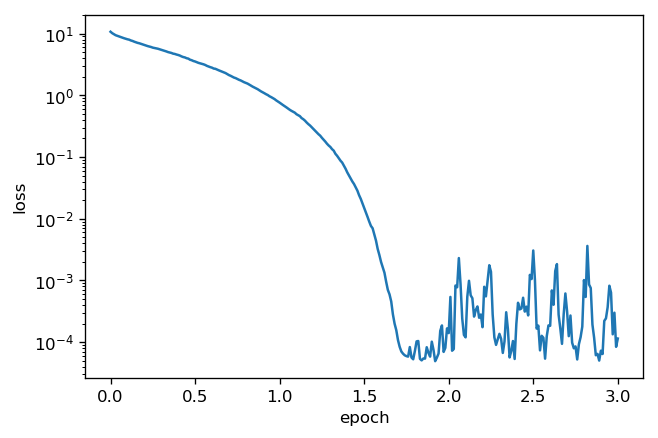

In [4]:
train(batch_size=10, lr=0.03, gamma=0.9, epochs=3, period=10)

将gamma调大一点，例如0.999。这时损失函数在迭代后期较平滑。

Batch size 10, Learning rate 0.030000, Epoch 1, loss 4.9827e-05
Batch size 10, Learning rate 0.030000, Epoch 2, loss 4.9708e-05
Batch size 10, Learning rate 0.030000, Epoch 3, loss 4.9287e-05
w: [[ 2.0002923  -3.40020919]] b: 4.20097 



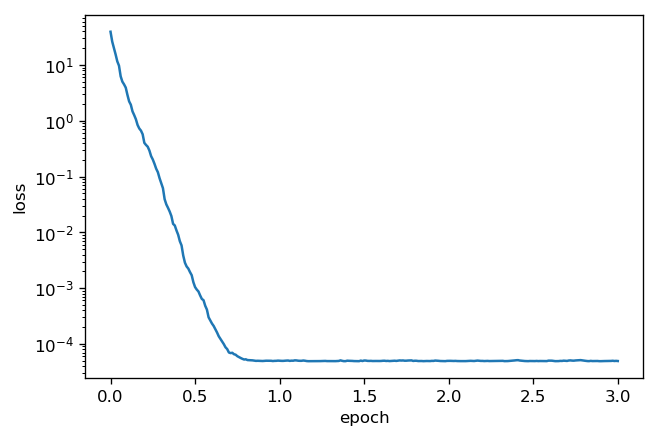

In [5]:
train(batch_size=10, lr=0.03, gamma=0.999, epochs=3, period=10)

### 结论

RMSProp和Adagrad的不同在于，RMSProp使用了梯度按元素平方的指数加权移动平均变量来调整学习率。
通过调整指数加权移动平均中gamma参数的值可以控制学习率的变化。

In [6]:

import mxnet as mx
from mxnet import autograd
from mxnet import gluon
from mxnet import ndarray as nd
import numpy as np
import random

mx.random.seed(1)
random.seed(1)

# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(scale=1, shape=y.shape)
dataset = gluon.data.ArrayDataset(X, y)

net = gluon.nn.Sequential()
net.add(gluon.nn.Dense(1))
square_loss = gluon.loss.L2Loss()

In [7]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def train(batch_size, lr, gamma, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)
    # RMSProp。
    trainer = gluon.Trainer(net.collect_params(), 'rmsprop',
                            {'learning_rate': lr, 'gamma1': gamma})
    data_iter = gluon.data.DataLoader(dataset, batch_size, shuffle=True)
    total_loss = [np.mean(square_loss(net(X), y).asnumpy())]

    for epoch in range(1, epochs + 1):
        for batch_i, (data, label) in enumerate(data_iter):
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X), y).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" %
              (batch_size, trainer.learning_rate, epoch, total_loss[-1]))

    print('w:', np.reshape(net[0].weight.data().asnumpy(), (1, -1)),
          'b:', net[0].bias.data().asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Batch size 10, Learning rate 0.030000, Epoch 1, loss 7.5963e-01
Batch size 10, Learning rate 0.030000, Epoch 2, loss 1.4022e-04
Batch size 10, Learning rate 0.030000, Epoch 3, loss 1.1444e-04
w: [[ 2.00390148 -3.39570284]] b: 4.20971 



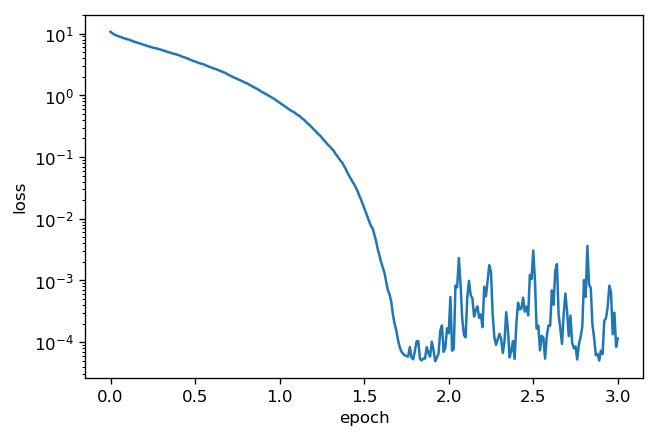

In [8]:
train(batch_size=10, lr=0.03, gamma=0.9, epochs=3, period=10)

Batch size 10, Learning rate 0.030000, Epoch 1, loss 4.9827e-05
Batch size 10, Learning rate 0.030000, Epoch 2, loss 4.9708e-05
Batch size 10, Learning rate 0.030000, Epoch 3, loss 4.9287e-05
w: [[ 2.0002923  -3.40020895]] b: 4.20097 



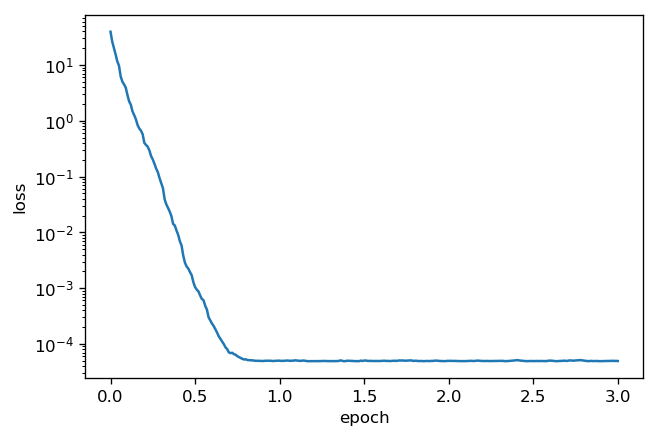

In [9]:
train(batch_size=10, lr=0.03, gamma=0.999, epochs=3, period=10)